In [ ]:
# Importing necessary libraries 
import pandas as pd
import seaborn as sns
import numpy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_selection import SelectKBest, f_classif

# Load and Clean Data

In [2]:
# Load the dataset from a CSV file into a pandas DataFrame
df=pd.read_csv("DSCI 5240 Project Data.csv")

In [3]:
# Display the entire DataFrame to examine the data
df

,Water Pump ID,Water Source Type,Water Quality,Distance to Nearest Town,Population Served,Installation Year,Funder,Payment Type,Water Pump Age,Pump Type,GPS Coordinates,Functioning Status
0,WP001,Well,Clean,44.0,13000.0,2006.0,World Bank,Free,18.0,Motorized Pump,"(-20.599463060030295, 26.696000047794744)",Functioning
1,WP002,Lake,Clean,13.0,13000.0,1990.0,Red Cross,Free,34.0,Hand Pump,"(-20.69129769992364, 23.313405231404484)",Not Functioning
2,WP003,Lake,Clean,27.0,12000.0,1997.0,Oxfam,Pay per use,27.0,Hand Pump,"(-19.830951420391948, 26.650358442338003)",Not Functioning
3,WP004,Well,Clean,14.0,9000.0,1992.0,Oxfam,Pay per use,32.0,NaN,"(-22.335866062765565, 22.83485684389231)",Functioning
4,WP005,Lake,Clean,41.0,16000.0,2006.0,NaN,Pay per use,18.0,Hand Pump,"(-21.099305692773278, 24.799143614430015)",Functioning
...,...,...,...,...,...,...,...,...,...,...,...,...
4995,WP4996,Lake,Clean,51.0,13000.0,2009.0,Red Cross,Pay per use,15.0,Hand Pump,"(-17.796214538366613, 19.695454081461676)",Functioning
4996,WP4997,Well,NaN,44.0,10000.0,2003.0,Oxfam,Free,21.0,Hand Pump,NaN,Functioning
4997,WP4998,Lake,Contaminated,35.0,16000.0,NaN,UNICEF,Pay per use,24.0,Hand Pump,"(-17.97187353787052, 24.88950846820186)",Not Functioning
4998,WP4999,Well,Clean,35.0,14000.0,1993.0,USAID,Pay per use,NaN,Hand Pump,"(-18.769781019824762, 27.28436990576585)",Not Functioning


In [7]:
#Data types in the dataset
df.dtypes

Water Pump ID                object
Water Source Type            object
Water Quality                object
Distance to Nearest Town    float64
Population Served           float64
Installation Year           float64
Funder                       object
Payment Type                 object
Water Pump Age              float64
Pump Type                    object
GPS Coordinates              object
Functioning Status           object
dtype: object

In [3]:
# Check the number of missing values in each column
df.isnull().sum()

Water Pump ID               250
Water Source Type           250
Water Quality               250
Distance to Nearest Town    250
Population Served           250
Installation Year           250
Funder                      250
Payment Type                250
Water Pump Age              250
Pump Type                   250
GPS Coordinates             250
Functioning Status          250
dtype: int64

In [4]:
# Drop rows where the target variable 'Functioning Status' is missing
df = df.dropna(subset=["Functioning Status"])

# Exploratory Data Analysis

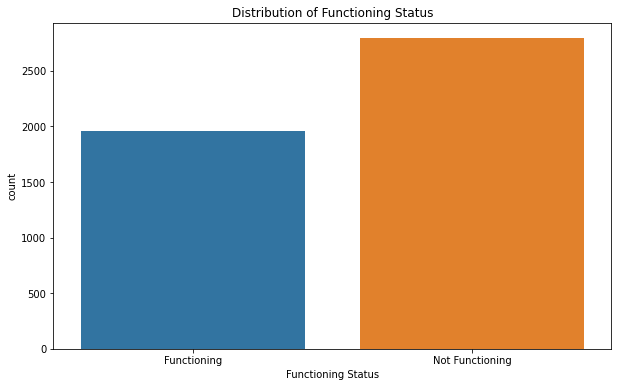

In [23]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Functioning Status', data=df)
plt.title('Distribution of Functioning Status')
plt.show()

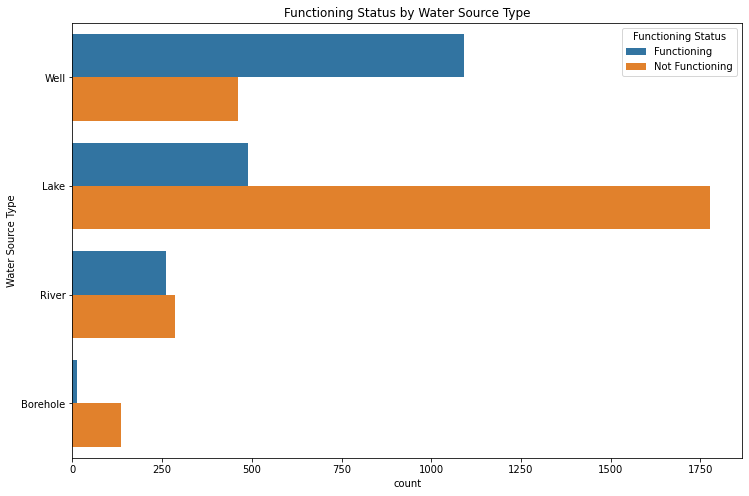

In [8]:
plt.figure(figsize=(12, 8))
sns.countplot(y='Water Source Type', hue='Functioning Status', data=df)
plt.title('Functioning Status by Water Source Type')
plt.show()

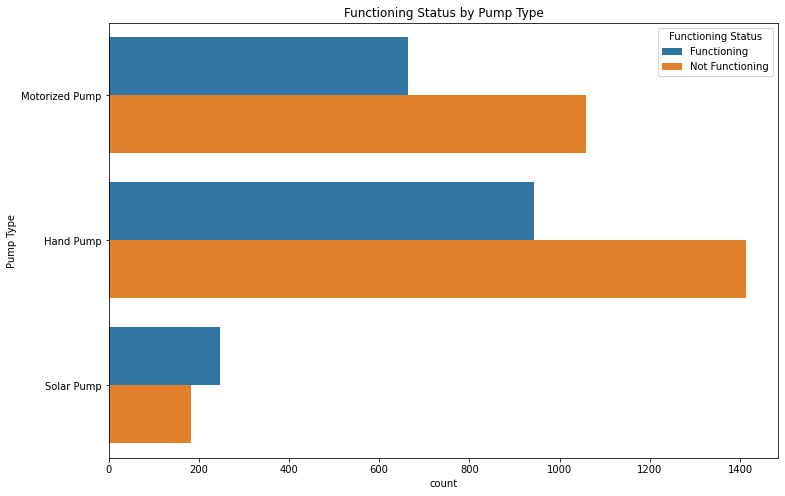

In [9]:
plt.figure(figsize=(12, 8))
sns.countplot(y='Pump Type', hue='Functioning Status', data=df)
plt.title('Functioning Status by Pump Type')
plt.show()

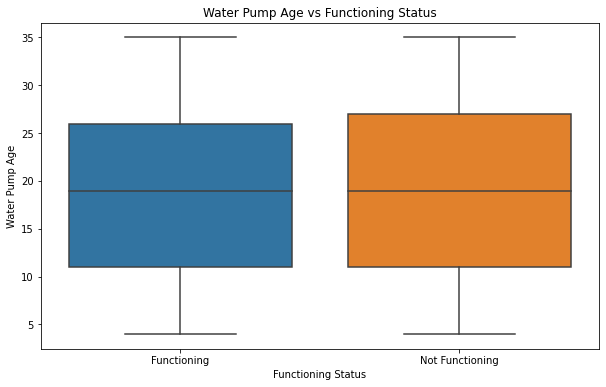

In [24]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Functioning Status', y='Water Pump Age', data=df)
plt.title('Water Pump Age vs Functioning Status')
plt.show()

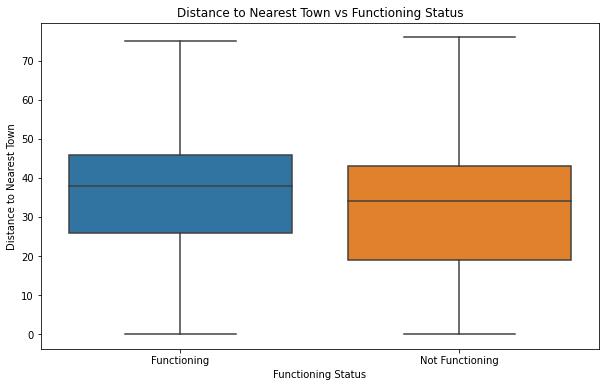

In [25]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Functioning Status', y='Distance to Nearest Town', data=df)
plt.title('Distance to Nearest Town vs Functioning Status')
plt.show()

In [6]:
# Convert Functioning Status to binary (1 for Functioning, 0 for Not Functioning)
df['Functioning Status'] = df['Functioning Status'].apply(lambda x: 1 if x == 'Functioning' else 0)

Correlation analysis

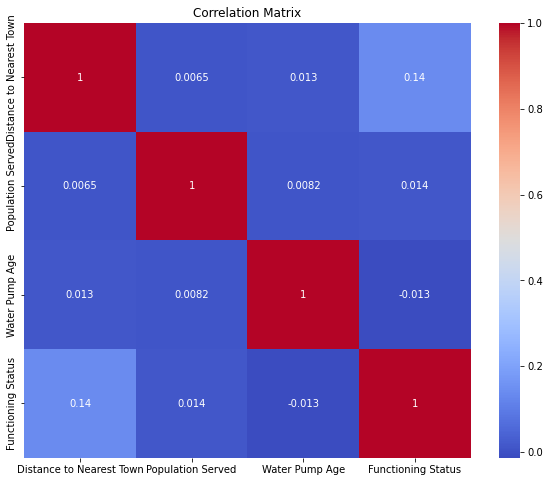

In [27]:

numeric_features = ['Distance to Nearest Town', 'Population Served', 
                    'Water Pump Age']
corr_matrix = df[numeric_features + ['Functioning Status']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Feature Engineering

In [5]:
# Convert Water Pump Age to numeric, filling missing values with current year - installation year
current_year = pd.Timestamp.now().year
installation_year_median = df['Installation Year'].median()
df['Installation Year'] = df['Installation Year'].fillna(installation_year_median)
df['Water Pump Age'] = df['Water Pump Age'].fillna(current_year - df['Installation Year'])

In [7]:
# Convert GPS coordinates to separate numeric columns
df[['Latitude', 'Longitude']] = (
    df["GPS Coordinates"]
    .str.extract(r'\(([-\d.]+),\s*([-\d.]+)\)')
    .astype(float)
)

In [8]:
# Create missing indicator for GPS coordinates
df['GPS_Missing'] = df['GPS Coordinates'].isna().astype(int)

In [9]:
# Drop redundant columns no longer needed after feature extraction
df = df.drop(['Water Pump ID', 'GPS Coordinates', 'Installation Year'], axis=1)

# Data Preparation and Splitting

In [10]:
# Define features and target variable
X = df.drop('Functioning Status', axis=1)  # Fix typo in column name
y = df['Functioning Status']

#Split the data into training and testing sets with stratified sampling
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42)

# Data Preprocessing Pipeline

In [11]:
# Identify numerical and categorical feature columns
numerical_features = ['Distance to Nearest Town', 'Population Served', 
                     'Water Pump Age', 'Latitude', 'Longitude']
categorical_features = ['Water Source Type', 'Water Quality', 'Funder',
                       'Payment Type', 'Pump Type']
missing_indicator = ['GPS_Missing']

In [12]:
# Pipeline for numerical data: KNN imputation followed by standard scaling
numerical_transformer = Pipeline([
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler())
])

# Pipeline for categorical data: Mode imputation followed by OneHotEncoding
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

In [13]:
# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer([
    ('num', numerical_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_features),
    ('missing', 'passthrough', missing_indicator)           # Keep GPS_Missing as is
])

In [14]:
# Add feature selection
feature_selector = SelectKBest(score_func=f_classif, k='all')

# Model Selection and Building

In [74]:
# Instantiate classifiers - Logistic Regression, Random Forest, Gradient Boosting, XGBoost and Neural Network
models={
    'LogisticRegression': {
        'model': Pipeline([
            ('preprocessor', preprocessor),
            ('selector', feature_selector),
            ('classifier', LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000))
        ]),
        'params': {
            'classifier__C': [0.01, 0.1, 1, 10],
            'classifier__solver': ['liblinear', 'saga'],
            'classifier__penalty': ['l1','l2']
        }
    },
    'RandomForest': {
        'model': Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', RandomForestClassifier(class_weight='balanced', random_state=42))
        ]),
        'params': {
            'classifier__n_estimators': [100, 200, 300],
            'classifier__max_depth': [None, 10, 20, 30],
            'classifier__min_samples_split': [2, 5, 10],
            'classifier__max_features': ['sqrt', 0.8, 0.5],
            'classifier__bootstrap': [True,False]
        }
    },
    'Gradient Boosting':{
        'model': Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', GradientBoostingClassifier(random_state=42))
        ]),
        'params': {
            'classifier__n_estimators': [100, 200, 300],
            'classifier__learning_rate': [0.001, 0.01, 0.05, 0.1],
            'classifier__max_depth': [3, 4, 5, 6],
            'classifier__min_samples_split': [2, 5, 10],
            'classifier__min_samples_leaf': [1, 3, 5],
            'classifier__subsample': [0.6, 0.8, 1.0],
            'classifier__max_features': ['sqrt', 'log2', None]
        }
    },
    'XGBoost': {
        'model': Pipeline([
            ('preprocessor', preprocessor),
            ('selector', feature_selector),
            ('classifier', XGBClassifier(
                objective='binary:logistic',
                eval_metric='logloss',
                use_label_encoder=False,
                random_state=42
            ))
        ]),
        'params': {
            'classifier__n_estimators': [100, 200],
            'classifier__max_depth': [3, 5, 7],
            'classifier__learning_rate': [0.01, 0.05, 0.1],
            'classifier__subsample': [0.8, 1.0],
            'classifier__colsample_bytree': [0.8, 1.0]
        }
    },
    'NeuralNetwork': {
        'model': Pipeline([
            ('preprocessor', preprocessor),
            ('feature_selector', RFE(
                RandomForestClassifier(class_weight='balanced', random_state=42),
                n_features_to_select=10)),
            ('classifier', MLPClassifier(
                hidden_layer_sizes=(64, 32, 16), 
                solver='sgd',                     
                learning_rate_init=0.01,         
                batch_size=32,           
                max_iter=100, 
                random_state=42,
                activation='relu',              
                early_stopping=True,       
                verbose=True            
            ))
        ]), 
        'params': {
            'classifier__hidden_layer_sizes': [
                (64, 32, 16), 
                (128, 64)
            ],
            'classifier__activation': ['relu', 'tanh'],
            'classifier__solver': ['sgd', 'adam'],
            'classifier__learning_rate_init': [0.001, 0.01, 0.1],
            'classifier__alpha': [0.0001, 0.001, 0.01],  # L2 regularization
            'classifier__batch_size': [16, 32, 64],
            'classifier__max_iter': [100, 200]
        }
    }
}

In [75]:
# Model training using GridSearch and StratifiedKFold
best_models = {}
results = []

for name, config in models.items():
    grid_search = RandomizedSearchCV(
        estimator=config['model'],
        param_distributions=config['params'],    
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X_train, y_train)
    
    best_models[name] = grid_search.best_estimator_
    
    # Predict on test data
    y_pred = grid_search.best_estimator_.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    results.append({
        'model': name,
        'best_params': grid_search.best_params_,
        'test_accuracy': accuracy
    })

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Iteration 1, loss = 0.64662492
Validation score: 0.763158
Iteration 2, loss = 0.58032906
Validation score: 0.793233
Iteration 1, loss = 0.76860006
Iteration 3, loss = 0.56982083
Validation score: 0.612782
Validation score: 0.785714
Iteration 4, loss = 0.56564427
Validation score: 0.800752
Iteration 2, loss = 0.77748850
Validation score: 0.413534
Iteration 5, loss = 0.56357040
Validation score: 0.793233
Iteration 1, loss = 0.72888353
Validation score: 0.593985
Iteration 1, loss = 0.71871992
Validation score: 0.609023
Iteration 1, loss = 0.64792032
Validation score: 0.748120
Iteration 6, loss = 0.55995860
Validation score: 0.796992
Iteration 3, loss = 0.73495591
Validation score: 0.586466

In [76]:
# Display results for each of the trained models
results_df = pd.DataFrame(results)
print("\nModel Comparison Results:")
print(results_df[['model', 'test_accuracy']])


Model Comparison Results:
                model  test_accuracy
0  LogisticRegression       0.735439
1        RandomForest       0.741754
2   Gradient Boosting       0.745263
3             XGBoost       0.741754
4       NeuralNetwork       0.727719


In [77]:
# Best model selection
best_model_name = results_df.loc[results_df['test_accuracy'].idxmax(), 'model']
best_model = best_models[best_model_name]
print(f"\nBest Model: {best_model_name} with test accuracy: {results_df['test_accuracy'].max():.4f}") 


Best Model: Gradient Boosting with test accuracy: 0.7453


# Ensemble Learning with Voting Classifier

In [78]:
# In the Ensemble Learning, the two highest performing models (XGBoost and Gradient Boosting) are used
ensemble = VotingClassifier(
    estimators=[
        ('xgb', best_models['XGBoost']),
        ('gb', best_models['Gradient Boosting'])
    ],
    voting='soft'  # soft = use predicted probabilities
)

# Fit ensemble model
ensemble.fit(X_train, y_train)
ensemble_pred = ensemble.predict(X_test)
ensemble_accuracy = accuracy_score(y_test, ensemble_pred)

results.append({
    'model': 'VotingEnsemble (XGB + GB)',
    'best_params': 'N/A',
    'test_accuracy': ensemble_accuracy
})

In [79]:
# Display results
results_df = pd.DataFrame(results)
print("\nModel Comparison Results:")
print(results_df[['model', 'test_accuracy']])


Model Comparison Results:
                       model  test_accuracy
0         LogisticRegression       0.735439
1               RandomForest       0.741754
2          Gradient Boosting       0.745263
3                    XGBoost       0.741754
4              NeuralNetwork       0.727719
5  VotingEnsemble (XGB + GB)       0.745965


In [93]:
# Revised Best model selection
best_model_name = results_df.loc[results_df['test_accuracy'].idxmax(), 'model']
print(f"\nAfter the model stacking/ensembling, Best Model: {best_model_name} with test accuracy: {results_df['test_accuracy'].max():.4f}") 


After the model stacking/ensembling, Best Model: VotingEnsemble (XGB + GB) with test accuracy: 0.7460


# Feature Importance

In [101]:
# Feature importance analysis
if hasattr(best_model.named_steps['classifier'], 'feature_importances_'):
    feature_names = numerical_features + \
        list(best_model.named_steps['preprocessor']
            .named_transformers_['cat']
            .named_steps['encoder']
            .get_feature_names_out(categorical_features)) + \
        missing_indicator
    
    importances = best_model.named_steps['classifier'].feature_importances_
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    print("\nAll the Features:")
    print(feature_importance_df)


All the Features:
                       feature  importance
8       Water Source Type_Well    0.325993
6       Water Source Type_Lake    0.215224
0     Distance to Nearest Town    0.093884
3                     Latitude    0.044412
5   Water Source Type_Borehole    0.042678
9          Water Quality_Clean    0.035018
10  Water Quality_Contaminated    0.034980
4                    Longitude    0.028917
20        Pump Type_Solar Pump    0.025446
7      Water Source Type_River    0.024864
1            Population Served    0.024276
11                Funder_Oxfam    0.023061
2               Water Pump Age    0.020106
13               Funder_UNICEF    0.013808
15           Funder_World Bank    0.008790
17    Payment Type_Pay per use    0.008075
12            Funder_Red Cross    0.008018
19    Pump Type_Motorized Pump    0.006923
16           Payment Type_Free    0.005951
14                Funder_USAID    0.005072
18         Pump Type_Hand Pump    0.002575
21                 GPS_Missing    0

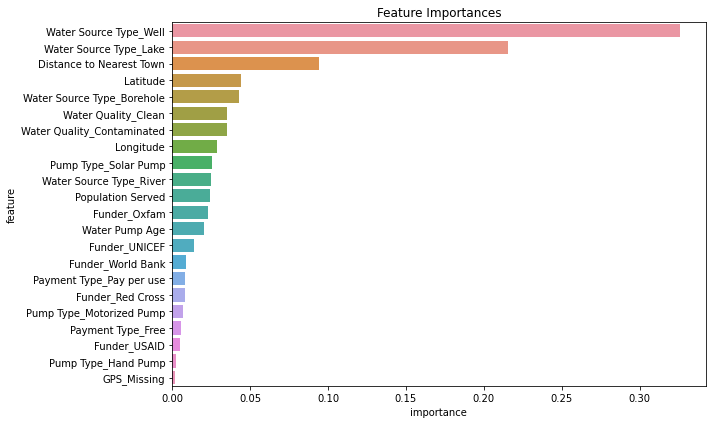

In [95]:
# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('Feature Importances')
plt.tight_layout()
plt.show()

In [99]:
# Generate classification report
y_pred = ensemble.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.82      0.79       838
           1       0.72      0.64      0.67       587

    accuracy                           0.75      1425
   macro avg       0.74      0.73      0.73      1425
weighted avg       0.74      0.75      0.74      1425

